Primal-Dual Splitting Algorithm and application to image analysis
==============================
Adapted from Laurent Condat and Gabriel Peyré notebooks
$\newcommand{\umin}[1]{\underset{#1}{\min}\;}$
$\newcommand{\dotp}[2]{\langle #1, #2 \rangle}$
$\newcommand{\enscond}[2]{\lbrace #1, #2 \rbrace}$
$\newcommand{\pd}[2]{ \frac{ \partial #1}{\partial #2} }$
$\newcommand{\umin}[1]{\underset{#1}{\min}\;}$
$\newcommand{\umax}[1]{\underset{#1}{\max}\;}$
$\newcommand{\umin}[1]{\underset{#1}{\min}\;}$
$\newcommand{\uargmin}[1]{\underset{#1}{argmin}\;}$
$\newcommand{\norm}[1]{\|#1\|}$
$\newcommand{\abs}[1]{\left|#1\right|}$
$\newcommand{\choice}[1]{ \left\{  \begin{array}{l} #1 \end{array} \right. }$
$\newcommand{\pa}[1]{\left(#1\right)}$
$\newcommand{\diag}[1]{{diag}\left( #1 \right)}$
$\newcommand{\qandq}{\quad\text{and}\quad}$
$\newcommand{\qwhereq}{\quad\text{where}\quad}$
$\newcommand{\qifq}{ \quad \text{if} \quad }$
$\newcommand{\qarrq}{ \quad \Longrightarrow \quad }$
$\newcommand{\ZZ}{\mathbb{Z}}$
$\newcommand{\CC}{\mathbb{C}}$
$\newcommand{\RR}{\mathbb{R}}$
$\newcommand{\EE}{\mathbb{E}}$
$\newcommand{\Zz}{\mathcal{Z}}$
$\newcommand{\Ww}{\mathcal{W}}$
$\newcommand{\Vv}{\mathcal{V}}$
$\newcommand{\Nn}{\mathcal{N}}$
$\newcommand{\NN}{\mathcal{N}}$
$\newcommand{\Hh}{\mathcal{H}}$
$\newcommand{\Bb}{\mathcal{B}}$
$\newcommand{\Ee}{\mathcal{E}}$
$\newcommand{\Cc}{\mathcal{C}}$
$\newcommand{\Gg}{\mathcal{G}}$
$\newcommand{\Ss}{\mathcal{S}}$
$\newcommand{\Pp}{\mathcal{P}}$
$\newcommand{\Ff}{\mathcal{F}}$
$\newcommand{\Xx}{\mathcal{X}}$
$\newcommand{\Mm}{\mathcal{M}}$
$\newcommand{\Ii}{\mathcal{I}}$
$\newcommand{\Dd}{\mathcal{D}}$
$\newcommand{\Ll}{\mathcal{L}}$
$\newcommand{\Tt}{\mathcal{T}}$
$\newcommand{\si}{\sigma}$
$\newcommand{\al}{\alpha}$
$\newcommand{\la}{\lambda}$
$\newcommand{\ga}{\gamma}$
$\newcommand{\Ga}{\Gamma}$
$\newcommand{\La}{\Lambda}$
$\newcommand{\si}{\sigma}$
$\newcommand{\Si}{\Sigma}$
$\newcommand{\be}{\beta}$
$\newcommand{\de}{\delta}$
$\newcommand{\De}{\Delta}$
$\newcommand{\phi}{\varphi}$
$\newcommand{\th}{\theta}$
$\newcommand{\om}{\omega}$
$\newcommand{\Om}{\Omega}$

This lecture explores the primal-dual proximal splitting algorithm proposed in 

**A. Chambolle and T. Pock**, "A First-order primal-dual algorithm for convex problems with application to imaging,"
_Journal of Mathematical Imaging and Vision_,
vol. 40, no. 1, 2011

and further analyzed and extended in 

**L. Condat**, "A primal-dual splitting method for convex optimization involving Lipschitzian, proximable and linear composite terms," _J. Optimization Theory and Applications_, vol. 158, no. 2, 2013.

In [102]:
from __future__ import division
import numpy as np
import scipy as scp
import pylab as pyl
import matplotlib.pyplot as plt

from nt_toolbox.general import *
from nt_toolbox.signal import *
from numpy import *
from numpy.fft import *
from numpy.random import *
from numpy.linalg import *
from scipy.misc import *

import warnings
warnings.filterwarnings('ignore')


Convex Optimization with a Primal-Dual Scheme
---------------------------------------------

We consider a (primal) optimization problem of the form
$$ \umin{x\in X} F(x) + G(Lx) $$
where $F:X\to\RR$ and $G:Y\to\RR$ are convex functions over HIbert spaces $X$ and $Y$, whose proximity operators can be computed, and $L:X\to Y$ is a linear operator.

Introducing the Fenchel conjugate $G^*$ of $G$, this problem could be written as 
$$ \umin{x\in X}\umin{y\in Y} <Lx,y>+F(x)-G^*(y)$$
Several problems of image analysis could be cast into this framework.

For the primal-dual algorithm to be applicable, one should be able to
compute efficiently the proximal mapping of $F$ and $G$, defined as:
$$ \text{Prox}_{\gamma F}(x) = \uargmin{y} \frac{1}{2}\norm{x-y}^2 + \ga F(y) $$
(the same definition applies also for $G$).



- **Denoising TV - ROF**

*Idea:* to denoise an image $\mathbf{I}$ by minimizing the $L^1$ norm of the gradient of reconstructed image, and $L^2$ norm from the original image. The problem therefore reads
$$\umin{u}\int_\Omega|\nabla u|dx+\frac\lambda2\|u-\mathbf{I}\|_2^2$$
where $L(u)=\nabla u$ and $F$ is the $L^1$ norm.

- **Denoising TV - ROF - L1**

Version with the $L^1$ norm on the fidelity to image term. The problem therefore reads
$$\umin{u}\int_\Omega|\nabla u|dx+\frac\lambda2\|u-\mathbf{I}\|_1$$
where $L(u)=\nabla u$ and $F$ is the $L^1$ norm.


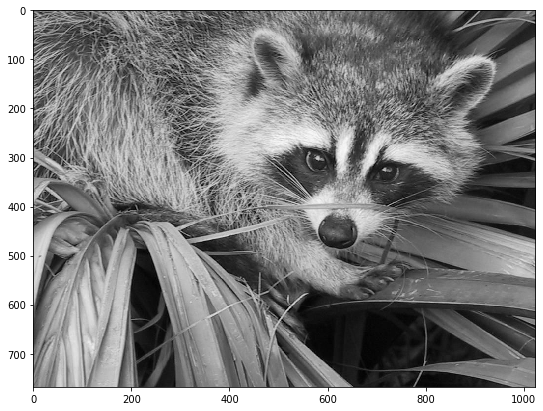

In [117]:
xsharp = face(gray=True)
xsharp = xsharp.astype(float32)
plt.figure(figsize=(9, 9))
plt.imshow(xsharp, interpolation='nearest', cmap='gray', vmin=0, vmax=255)

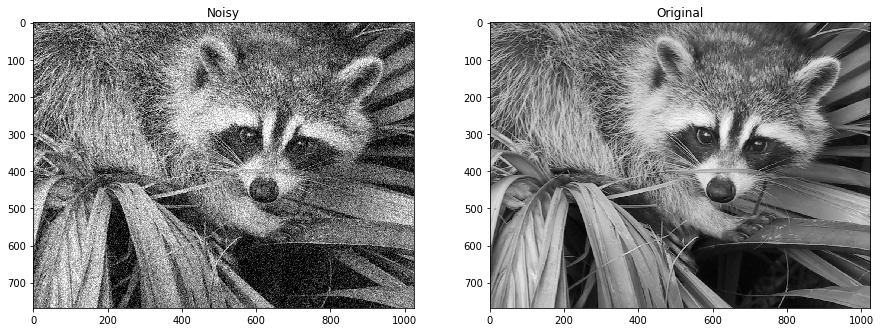

In [146]:
(N1,N2) = shape(xsharp)
noiselevel = 30
yn = xsharp + noiselevel * randn(N1,N2)
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(15, 15))
ax1.imshow(yn, interpolation='nearest', cmap='gray', vmin=0, vmax=255)
ax1.set_title("Noisy")
ax2.imshow(xsharp, interpolation='nearest', cmap='gray', vmin=0, vmax=255)
ax2.set_title("Original")
plt.show()


- **Dezooming and deconvolution**

More generally we can consider  a problem with a linear operator A:
$$\umin{u}\int_\Omega|\nabla u|dx+\frac\lambda2\|Au-\mathbf{I}\|_2^2$$
In case of deconvolution (or deblurring), A is a convolution operator, which can be numerically computed with FFT. In the case of dezooming, A is a sampling operator with regularization.


Operator $A$ is a blurring. Let us bluid it from a Gaussian kernel of width $3$, blur the image which is a product in the Fourier space, and display it.

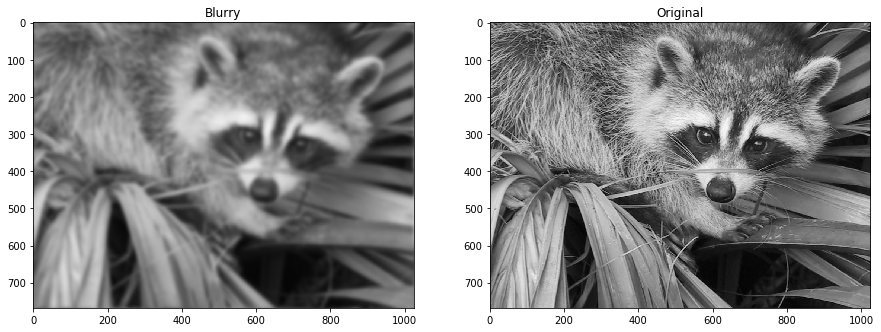

In [167]:
s = 5
xsharp = face(gray=True)
xsharp = xsharp.astype(float32)
(N1,N2) = shape(xsharp)
x = concatenate( (arange(0,N1/2), arange(-N1/2,0)) );
y = concatenate( (arange(0,N2y/2), arange(-N2/2,0)) );
[Y, X] = meshgrid(y, x)
h = exp((-X**2-Y**2)/ (2*s**2))
h = h/sum(h.flatten())
hF = real(fft2(h)) # the Fourier transform
Phi = lambda x,h: real(ifft2(fft2(x) * fft2(h))) # blurring function
yb = Phi(xsharp, h)
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(15, 15))
ax1.imshow(yb, interpolation='nearest', cmap='gray', vmin=0, vmax=255)
ax1.set_title("Blurry")
ax2.imshow(xsharp, interpolation='nearest', cmap='gray', vmin=0, vmax=255)
ax2.set_title("Original")
plt.show()


- **Inpainting**

Inpainting corresponds to filling holes in images. This corresponds to a linear ill posed inverse problem.

First we load the image to be inpainted and display it.

In [178]:
xsharp = face(gray=True)
xsharp = xsharp.astype(float32)
(N1,N2) = shape(xsharp)


Amount of removed pixels, and construction of damaged picture. The damaging operator put to zeros the pixel locations x for which $\Omega(x)=1$. Then we plot the observed damaged picture.

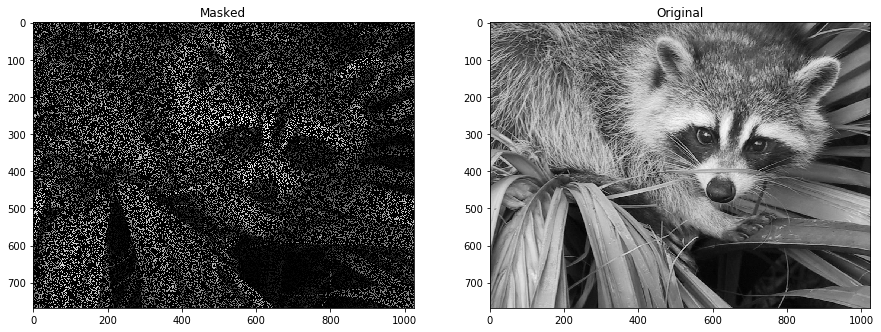

In [180]:
rho = .7

Omega = np.zeros([N1, N2])
arr=np.arange(N1*N2)
sel = np.random.permutation(arr)
np.ravel(Omega)[sel[np.arange(int(rho*N1*N2))]] = 1
Phi = lambda f, Omega: f*(1-Omega)
ym = Phi(xsharp, Omega)
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(15, 15))
ax1.imshow(ym, interpolation='nearest', cmap='gray', vmin=0, vmax=255)
ax1.set_title("Masked")
ax2.imshow(xsharp, interpolation='nearest', cmap='gray', vmin=0, vmax=255)
ax2.set_title("Original")
plt.show()

The dual problem is 

$$ \umin{u} F^*(-L^*u) + G^*(u) $$

The (relaxed) Chambolle-Pock algorithm takes initial estimates $x^{(0)}$ and $u^{(0)}$ of the primal and dual solutions, a parameter $\tau>0$, a second parameter $0<\sigma\leq 1/(\tau\|L\|^2)$, a relaxation parameter $0<\rho<2$, and iterates, for $k=1,2,\ldots$
$$ \left|\begin{array}{l}
\tilde{x}^{(k)} = \mathrm{prox}_{\tau F}(  x^{(k-1)}-\tau L^*(u^{(k-1)}) ) \\
 \tilde{u}^{(k)} = \mathrm{prox}_{\sigma G^*}( u^{(k-1)}+ \sigma L(2\tilde{x}^{(k)}-x^{(k-1)}) \\
 x^{(k)}= x^{(k-1)} + \rho (\tilde{x}^{(k)}-x^{(k-1)})\\
 u^{(k)}= u^{(k-1)} + \rho (\tilde{u}^{(k)}-u^{(k-1)})
 \end{array}\right.$$
 
 Then, $x^{(k)}$ converges to a primal solution $x^\star$ and $u^{(k)}$ converges to a dual solution $u^\star$.
 
 In practice, like for the Douglas-Rachford algorithm, it is always interesting to take $\rho$ close to $2$, e.g. $\rho=1.9$, instead of $\rho=1$ like in the paper of Chambolle & Pock. Also, for fixed $\tau$, the higher $\sigma$, the better; so, one can set $\sigma=1/(\tau\|L\|^2)$, which leaves only the parameter $\tau$ to tune.

With this choice of $\sigma$, the algorithm exactly reverts to the Douglas-Rachford algorithm when $L=\mathrm{Id}$ (replacing $\sigma$ by $1/\tau$ in the algorithm). So, it is a natural extension of the latter.


We recall that being able to compute the proximity operator of $F^*$ is
equivalent to being able to compute the proximity operator of $F$, thanks to the Moreau identity
$$ x = \mathrm{prox}_{\gamma F^*}(x) + \gamma \mathrm{prox}_{F/\gamma}(x/\gamma) $$

We define the discrete gradient operator $D$ and its adjoint $D^*$.

In [44]:
D = lambda x : c_['2,3',r_[diff(x,1,0), zeros([1,x.shape[1]])],c_[diff(x,1,1), zeros([x.shape[0],1])]]
Dadj = lambda v : r_['0,2',-v[0,:,0],-diff(v[:-1,:,0],1,0),v[-2,:,0]] + c_['1,2',-v[:,0,1],-diff(v[:,:-1,1],1,1),v[:,-2,1]]

The gradient of $F^*$ is simply $\nabla F^*:x\mapsto x+y$.

In [45]:
def grad_f_conj (x,y) :
    return x + y

The proximity operator $\text{prox}_{\ga g^*}$ does not depend on $\gamma$ and is such that$$\big(\text{prox}_{\ga g^*}(u)\big)_{n_1,n_2}=\frac{1}{\max(\|u_{n_1,n_2}\|_2/\lambda,1)}u_{n_1,n_2}\in\mathbb{R}^2,\quad\forall (n_1,n_2).$$

In [145]:
def prox_g_conj (u, Lambda) :
    return u/tile(maximum(sqrt(sum(u**2,2,keepdims=True))/Lambda,1),(1,1,2)) # soft-thresholding

Image denoising
-------------------------

In [147]:
Lambda = 25
gamma = 1.9/8 # we must have 0 < gamma < 2/8
nbiter = 500
(N1,N2) = yn.shape
u = zeros([N1,N2,2])
Ep_array = zeros(nbiter) # array for the primal energy E_p
Ed_array = zeros(nbiter) # array for the dual energy E_d
sqnormy = norm(yn)**2/2
for iter in range(nbiter):  
    x = grad_f_conj(-Dadj(u),yn)
    u = prox_g_conj(u + gamma*D(x), Lambda)
    Ep_array[iter] = norm(x-yn)**2/2 + Lambda*sum(sqrt(sum(D(x)**2,2))) 
    Ed_array[iter] = norm(yn-Dadj(u))**2/2 - sqnormy
xdenoised = x

Display of denoised image

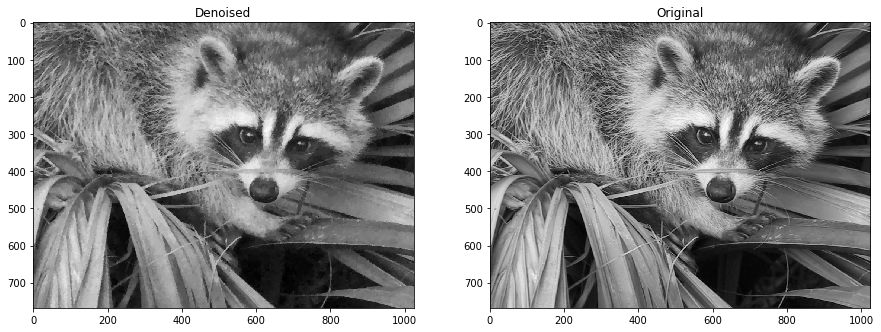

In [148]:
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(15, 15))
ax1.imshow(xdenoised, interpolation='nearest', cmap='gray', vmin=0, vmax=255)
ax1.set_title("Denoised")
ax2.imshow(xsharp, interpolation='nearest', cmap='gray', vmin=0, vmax=255)
ax2.set_title("Original")
plt.show()

Exercise : Implement deblurring and inpainting cases